In [1]:
import sys, os
import jax
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
from jax.example_libraries import stax
import jax.tree_util as tree_util # for applying learning rate to gradients
import pandas as pd

from matplotlib import pyplot as plt

In [2]:
src_dir = os.path.dirname("./src/")
sys.path.insert(0,src_dir)

In [3]:
from utils.dataloaders import krypton
# Load the sipm database:
sipm_db = pd.read_pickle("database/new_sipm.pkl")

dl = krypton(
    batch_size  = 32,
    db          = sipm_db,
    path        = "/Users/corey.adams/data/NEXT/new_raw_data",
    run         = 8678
    )

In [4]:
batch = next(dl.iterate())
key = random.PRNGKey(0)

In [5]:
parameters = []

In [6]:
def generate_electrons(energy_and_position, _key):
    '''
    Generate a sequence of electrons given an energy amount.
    A random number of electrons are generated, but a static-sized array 
    is returned.  This ensures jit'ing is possible later.
    The number of electrons in the array that is valid is also returned
    '''
    
    energy   = energy_and_position[-1]
    position = energy_and_position[0:3]
    
    # For each energy, compute n:
    n = energy* 1000.*1000. / 22.4
    sigmas = np.sqrt(n * 0.15)
    # Generate a sample for each energy:
    n_electrons = (sigmas*random.normal(_key) + n).astype(np.int32)
    
    shape = (2000, 3)
    el_arr = np.broadcast_to(position, shape)
    
    return el_arr, n_electrons

In [7]:
key, subkey = random.split(key)
print(batch['energy_deposits'][0][0])
generate_electrons(batch['energy_deposits'][0][0], subkey)

[-1.6410422e+02 -3.7705009e+01  3.0000376e+01  4.1557498e-02]


(DeviceArray([[-164.10422 ,  -37.70501 ,   30.000376],
              [-164.10422 ,  -37.70501 ,   30.000376],
              [-164.10422 ,  -37.70501 ,   30.000376],
              ...,
              [-164.10422 ,  -37.70501 ,   30.000376],
              [-164.10422 ,  -37.70501 ,   30.000376],
              [-164.10422 ,  -37.70501 ,   30.000376]], dtype=float32),
 DeviceArray(1834, dtype=int32))

In [8]:
%timeit -n 100 generate_electrons(batch['energy_deposits'][0][0], subkey)

452 µs ± 55.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
generate_electrons = jit(generate_electrons)


In [10]:
%timeit -n 1000 generate_electrons(batch['energy_deposits'][0][0], subkey)

The slowest run took 13.17 times longer than the fastest. This could mean that an intermediate result is being cached.
27.2 µs ± 41.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
# When vmap'd, it will generate the electron array for all the energy depositions in one event
generate_electrons_event = vmap(generate_electrons, in_axes=[0, None])

generate_electrons_event = jit(generate_electrons_event)


In [12]:
electrons, n_valid = generate_electrons_event(batch['energy_deposits'][0], subkey)

In [13]:
print(electrons.shape)

(2, 2000, 3)


In [14]:
%timeit -n 1000 electrons, n_valid = generate_electrons_event(batch['energy_deposits'][0], subkey)

15.3 µs ± 2.64 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [15]:
# VMAP one more time to process an entire batch:
generate_electrons_batch = vmap(generate_electrons_event, in_axes=[0,None])

In [16]:
electrons, n_valid = generate_electrons_batch(batch['energy_deposits'], subkey)

In [17]:
%timeit -n 100 generate_electrons_batch(batch['energy_deposits'], subkey)

603 µs ± 44.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
generate_electrons_batch = jit(generate_electrons_batch)
out = generate_electrons_batch(batch['energy_deposits'], subkey)

In [19]:
%timeit -n 100 generate_electrons_batch(batch['energy_deposits'], subkey)

89.1 µs ± 18.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
print(electrons.shape)

(32, 2, 2000, 3)


In [21]:
print(n_valid.shape)

(32, 2)


In [22]:
diffusion_scale = np.ones(3)
parameters.append(diffusion_scale)

In [23]:
def diffuse_electrons(electrons, diffusion_scale, _key):
    '''
    Apply diffusion to the electrons in a single energy deposition.
    '''
    
    # Then input should be an array of shape [max_electrons, 3]
    # only some of these are valid, but that's ok, it's not
    # that wasteful to diffuse them all.
    
    # Get the z position (we only need this as a scalar!):
    z = electrons[-1,-1]
    n_samples = electrons.shape[0]
    
    # Sample from a normal distribution:
    kicks = random.normal(_key, (electrons.shape))
    
    # Scale the kicks by the diffusion scale and sqrt(z)
    return electrons + z*diffusion_scale*kicks
    

In [24]:
single_en, single_valid = generate_electrons(batch['energy_deposits'][0][0], subkey)
out = diffuse_electrons(single_en, diffusion_scale, subkey)

In [25]:
%timeit -n 100 diffuse_electrons(single_en, diffusion_scale, subkey)


1.77 ms ± 38.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
diffuse_electrons = jit(diffuse_electrons)

In [27]:
%timeit -n 100 diffuse_electrons(single_en, diffusion_scale, subkey)


The slowest run took 12.66 times longer than the fastest. This could mean that an intermediate result is being cached.
341 µs ± 517 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
print(diffuse_electrons(single_en, diffusion_scale, subkey))

[[-168.91626   -25.858223   52.869476]
 [-171.4616    -61.647263   67.327034]
 [-222.9669    -43.530827   53.828682]
 ...
 [-134.67134   -90.67422    37.91455 ]
 [-185.19542   -21.963654  -22.016857]
 [-194.21474    19.421188   52.556507]]


In [29]:
single_en[-1][-1]

DeviceArray(30.000376, dtype=float32)

In [30]:
diffuse_electrons_event = jit(vmap(diffuse_electrons, in_axes=[0,None, None]))

In [31]:
event_el, event_valid = generate_electrons_event(batch['energy_deposits'][0], subkey)
out = diffuse_electrons_event(event_el, diffusion_scale, subkey)


In [32]:
%timeit -n 100 diffuse_electrons_event(event_el, diffusion_scale, subkey)

165 µs ± 22.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
print(out)
print(out.shape)

[[[-168.91626   -25.858223   52.869476]
  [-171.4616    -61.647263   67.327034]
  [-222.9669    -43.530827   53.828682]
  ...
  [-134.67134   -90.674225   37.91455 ]
  [-185.19542   -21.963654  -22.01686 ]
  [-194.21474    19.42119    52.556507]]

 [[   0.          0.          0.      ]
  [   0.          0.          0.      ]
  [   0.          0.          0.      ]
  ...
  [   0.          0.          0.      ]
  [   0.          0.          0.      ]
  [   0.          0.          0.      ]]]
(2, 2000, 3)


In [34]:
# Lastly, vmap one more time and get to the entire batch:
diffuse_electrons_batch = vmap(jit(diffuse_electrons_event), in_axes=[0,None, None])
electrons, n_valid = generate_electrons_batch(batch['energy_deposits'], subkey)


In [35]:
%timeit -n 100 diffuse_electrons_batch(electrons, diffusion_scale, subkey)

1.33 ms ± 584 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
output = diffuse_electrons_batch(electrons, diffusion_scale, subkey)

In [37]:
print(output.shape)

(32, 2, 2000, 3)


In [38]:
# Lastly, vmap one more time and get to the entire batch:
diffuse_electrons_batch = jit(vmap(diffuse_electrons_event, in_axes=[0,None, None]))
electrons, n_valid = generate_electrons_batch(batch['energy_deposits'], subkey)


In [39]:
%timeit -n 100 diffuse_electrons_batch(electrons, diffusion_scale, subkey)

837 µs ± 599 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [40]:
output = diffuse_electrons_batch(electrons, diffusion_scale, subkey)

In [41]:
output.shape

(32, 2, 2000, 3)

In [42]:
lifetime = np.asarray(100.)

In [43]:
# The lifetime gets finnicky if I put these two steps into one function.
# I don't know why yet.  But this works.  It also applies 0 weights to invalid electrons.


@jit
def s_compute_probability(_diffused_electrons, _lifetime):
    _z = _diffused_electrons[:,-1]
    probability = np.exp(- _z / _lifetime)

    return probability

@jit
def s_compute_mask(_diffused_electrons, _n_valid):
    # This technique is "stupid" but it jit's and vmap's, so it's not THAT stupid
    arange = np.arange(len(_diffused_electrons))
    mask = arange < _n_valid
    mask = mask.astype("float32")
    return mask

e_compute_probability = jit(vmap(s_compute_probability, in_axes=[0,None]))
compute_probability = jit(vmap(e_compute_probability, in_axes=[0,None]))

e_compute_mask = jit(vmap(s_compute_mask))
compute_mask = jit(vmap(e_compute_mask))
    
@jit
def compute_lifetime(electrons_batch, _lifetime, n_valid_batch):
    return compute_mask(electrons_batch, n_valid_batch) * compute_probability(electrons_batch, _lifetime)
    
# def split_lifetime(_diffused_electrons, _lifetime, _n_valid):
#     p = compute_probability(_diffused_electrons, _lifetime)
#     m = compute_mask(_diffused_electrons, _n_valid)
#     return p*m

In [44]:
electrons, n_valid = generate_electrons_batch(batch['energy_deposits'], subkey)
out_batch =  diffuse_electrons_batch(electrons, diffusion_scale, subkey)



In [45]:
%timeit -n 100 compute_lifetime(out_batch, lifetime, n_valid)

The slowest run took 5.95 times longer than the fastest. This could mean that an intermediate result is being cached.
242 µs ± 240 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [46]:
# PMT responses use a neural network.
# Input is a single energy depositions's worth of electrons, that turns into signals on a PMT

In [108]:
pmt_nn_init, pmt_nn_apply = stax.serial(
    stax.Dense(28), stax.Sigmoid,
    stax.Dense(12),
    stax.Sigmoid
)

pmt_response_scale = np.ones(12)

# We feed into the network a series of electrons:
single_en, single_valid = generate_electrons(batch['energy_deposits'][0][0], subkey)
single_out = diffuse_electrons(single_en, diffusion_scale, subkey)
input_shape = single_out[:,0:2].shape

probability = s_compute_probability(single_out, lifetime)
mask        = s_compute_mask(single_out, single_valid)

single_weights = probability*mask

key, supkey = random.split(key)

pmt_output_shape, pmt_params_initial = pmt_nn_init(subkey, input_shape)

In [109]:
pmt_output_shape

(2000, 12)

In [110]:
help(pmt_nn_apply)

Help on function apply_fun in module jax.example_libraries.stax:

apply_fun(params, inputs, **kwargs)



In [111]:
pmt_output = pmt_nn_apply(pmt_params_initial, single_out[:,0:2])

In [113]:
%timeit -n 100 pmt_nn_apply(pmt_params_initial, single_out[:,0:2])

935 µs ± 117 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [114]:
pmt_nn_apply = jit(pmt_nn_apply)

In [115]:
%timeit -n 100 pmt_nn_apply(pmt_params_initial, single_out[:,0:2])

909 µs ± 156 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [116]:
# We call the PMT function and need to VMAP / JIT it seperately:
event_pmt_nn_apply = jit(vmap(pmt_nn_apply, in_axes=[None, 0]))


In [117]:
event_el, event_valid = generate_electrons_event(batch['energy_deposits'][0], subkey)
out = diffuse_electrons_event(event_el, diffusion_scale, subkey)

event_pmt_output = event_pmt_nn_apply(pmt_params_initial, out[:,:,0:2])



In [118]:
print(event_pmt_output.shape)

(2, 2000, 12)


In [119]:
%timeit -n 100 event_pmt_nn_apply(pmt_params_initial, out[:,:,0:2])

1.1 ms ± 42.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [120]:
batch_pmt_nn_apply = jit(vmap(event_pmt_nn_apply, in_axes=[None, 0]))


In [121]:
electrons, n_valid = generate_electrons_batch(batch['energy_deposits'], subkey)
out_batch =  diffuse_electrons_batch(electrons, diffusion_scale, subkey)

batch_pmt_output = batch_pmt_nn_apply(pmt_params_initial, out_batch[:,:,:,0:2])


In [122]:
batch_pmt_output.shape

(32, 2, 2000, 12)

In [123]:
%timeit -n 10 batch_pmt_nn_apply(pmt_params_initial, out_batch[:,:,:,0:2])

10.8 ms ± 605 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [124]:
@jit
def build_waveforms(_sensor_response, _z_positions, _weights, _bin_sigma):
    '''
    Compute the PMT response to electrons on the EL region
    '''
    # This is basically a constant:
    _n_ticks=550
    
    n_electrons = _z_positions.shape[0]
    # Build a range for the exponential input:
    starts = np.zeros(shape=(n_electrons)) + 0.5
    stops  = np.ones(shape=(n_electrons)) * (_n_ticks -1) + 0.5
    
    # Reshape z positions for broadcasting:
    _z_positions = _z_positions.reshape((-1,1))
    
    exp_input = np.linspace(start=starts, stop=stops, num=_n_ticks, axis=-1)

    exp_values = np.exp( - (exp_input - _z_positions)**2.  / (2. * _bin_sigma))
    
    # Normalize the values:
    exp_values = exp_values.transpose() * (0.39894228040/np.sqrt(_bin_sigma))
    
    # Scale by the weights:
    exp_values = exp_values * _weights
    
    waveforms = np.matmul(exp_values, _sensor_response)
    
    return waveforms.transpose()
    

In [125]:
# Construct the PMT waveform for a single energy deposition like so:

parameters = {
    "diffusion"   : np.ones(3),
    "lifetime"    : np.asarray(10000.0),
    "pmt_network" : pmt_params_initial,
    "pmt_scale"   : np.ones(12), # Normalization per PMT
}


In [126]:


# Start with the single energy depositions:
s_generated_electrons, s_valid = generate_electrons(batch['energy_deposits'][0][0], subkey)
# Diffuse those electrons:
s_diffused = diffuse_electrons(s_generated_electrons, parameters["diffusion"], subkey)


# Calculate the weights as the probability * mask
# Recall this is vectorized and jit'd overall with a "real" function 
# but for some reason needs to be split.
s_probability = s_compute_probability(s_diffused, parameters["lifetime"])
s_mask        = s_compute_mask(s_diffused, s_valid)
s_weights     = s_probability * s_mask


# Next, split the diffused_electrons apart into xy and z:
s_xy = s_diffused[:,0:2]
s_z  = s_diffused[:,2:]

# Compute the pmt response:
s_pmt_response = pmt_nn_apply(parameters["pmt_network"], s_xy)
print(s_pmt_response[8].max())
# Use the response and the z positions to build the single waveforms:
s_pmt_waveforms = build_waveforms(s_pmt_response, s_z, s_weights, 0.1)

0.7459205


In [127]:
%timeit -n 100 build_waveforms(s_pmt_response, s_z, s_weights, 0.1)

952 µs ± 216 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [128]:
s_diffused[:,2:].shape

(2000, 1)

In [129]:
print(s_pmt_waveforms.shape)
print(s_pmt_waveforms[0].shape)

(12, 550)
(550,)


15.459593
851.972412109375


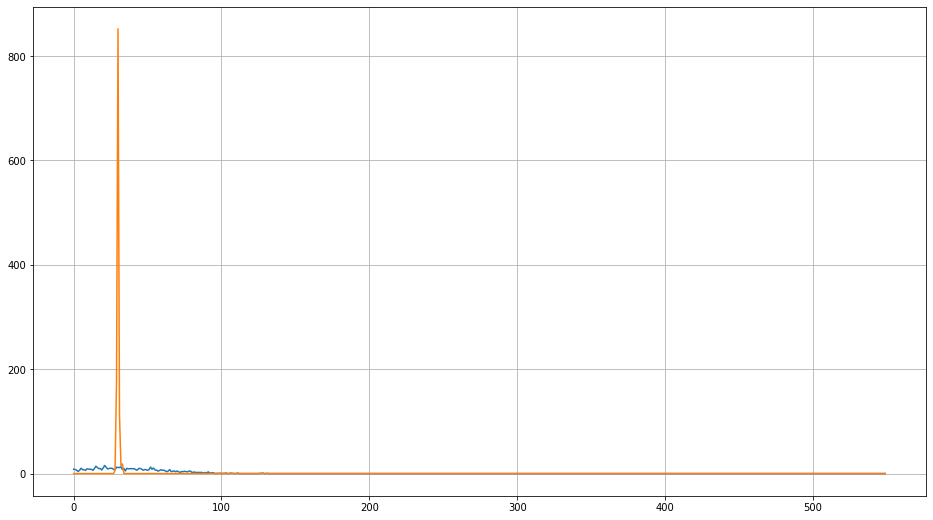

In [130]:
fig = plt.figure(figsize=(16,9))
x = np.arange(550)

i_pmt = 4
m = batch["S2Pmt"][0][i_pmt].max()
print(s_pmt_waveforms[i_pmt].max())
print(m)
plt.plot(x, s_pmt_waveforms[i_pmt])
plt.plot(x, batch["S2Pmt"][0][i_pmt])
plt.grid(True)

In [131]:


# Start with the single energy depositions:
e_generated_electrons, e_valid = generate_electrons_event(batch['energy_deposits'][0], subkey)
# Diffuse those electrons:
e_diffused = diffuse_electrons_event(e_generated_electrons, parameters["diffusion"], subkey)

# Calculate the weights as the probability * mask
# Recall this is vectorized and jit'd overall with a "real" function 
# but for some reason needs to be split.
e_probability = e_compute_probability(e_diffused, parameters["lifetime"])
e_mask        = e_compute_mask(e_diffused, e_valid)
e_weights     = e_probability * e_mask



# Next, split the diffused_electrons apart into xy and z:
e_xy = e_diffused[:,:,0:2]
e_z  = e_diffused[:,:,2:]

print("e_xy.shape: ", e_xy.shape)
print("e_z.shape: ", e_z.shape)
print("e_weights.shape: ", e_weights.shape)

# Compute the pmt response:
e_pmt_response = event_pmt_nn_apply(parameters["pmt_network"], e_xy)

print("e_pmt_response.shape: ", e_pmt_response.shape)

e_build_waveforms = jit(vmap(build_waveforms, in_axes=[0,0,0,None,]))



# Use the response and the z positions to build the single waveforms:
e_pmt_waveforms = e_build_waveforms(e_pmt_response, e_z, e_weights, 0.2)
# ^ This has an extra axis that needs to be reduced.
e_pmt_waveforms = e_pmt_waveforms.sum(axis=0)


e_xy.shape:  (2, 2000, 2)
e_z.shape:  (2, 2000, 1)
e_weights.shape:  (2, 2000)
e_pmt_response.shape:  (2, 2000, 12)


In [132]:
%timeit -n 100 e_build_waveforms(e_pmt_response, e_z, e_weights, 0.2)

1.94 ms ± 148 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [133]:
# Finally, put the whole thing together for a batch
batch_el, batch_valid = generate_electrons_batch(batch['energy_deposits'], subkey)
batch_diffused = diffuse_electrons_batch(batch_el, parameters['diffusion'], subkey)

lifetime = compute_lifetime(batch_diffused, parameters["lifetime"], batch_valid)


# Split the diffused electrons:
batch_xy = batch_diffused[:,:,:,0:2]
batch_z  = batch_diffused[:,:,:,2:]

batch_pmt_response = batch_pmt_nn_apply(parameters["pmt_network"], batch_xy)

print(batch_pmt_response.shape)

batch_build_waveforms = jit(vmap(e_build_waveforms, in_axes=[0,0,0,None,]))


batch_pmt_waveforms = batch_build_waveforms(batch_pmt_response, batch_z, lifetime, 0.2)

# Again, sum across the event dimension:
batch_pmt_waveforms = batch_pmt_waveforms.sum(axis=1)
print(batch_pmt_waveforms.shape)



(32, 2, 2000, 12)
(32, 12, 550)


In [134]:
# Build the whole thing as a function we can JIT:
@jit
def simulate_pmts(energy_depositions, _key, parameters):
    _generated_electrons, _valid_electrons = \
        generate_electrons_batch(energy_depositions, _key)
    _diffused = \
        diffuse_electrons_batch(_generated_electrons, parameters['diffusion'], _key)

    lifetime = compute_lifetime(_diffused, parameters["lifetime"], _valid_electrons)

    # Split off the XY and Z:
    
    _diffused_xy = _diffused[:,:,:,0:2]
    _diffused_z  = _diffused[:,:,:,2:]
    
    # Compute the PMT response:
    pmt_response = batch_pmt_nn_apply(parameters["pmt_network"], _diffused_xy)

    # Compute the waveforms:
    pmt_waveforms = batch_build_waveforms(pmt_response, _diffused_z, lifetime, 0.2)
    # Sum over the individual depositions:
    pmt_waveforms = pmt_waveforms.sum(axis=1)
    return pmt_waveforms


In [135]:
temp = simulate_pmts(batch["energy_deposits"], subkey, parameters)

In [136]:

key, subkey = random.split(key)
%timeit -n 1 simulate_pmts(batch["energy_deposits"], subkey, parameters)


159 ms ± 12.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [137]:
key, subkey = random.split(key)
simulated_pmts = simulate_pmts(batch["energy_deposits"], subkey, parameters)

In [138]:
# A function to compute the loss per batch:

@jit
def compute_loss(simulated_waveforms, real_waveforms):
    # First, we compute the difference squared in the two:
    difference = (simulated_waveforms - real_waveforms)**2.
    # Because this data is so sparse, we multiply the squared difference
    # by the input data to push the loss up in important places and
    # down in unimportant places.  But, don't want the loss to be zero 
    # where the wavefunction is zero, so put a floor:
    loss = difference
#     loss = difference * (real_waveforms + 1e-4)
    
    # And, return the loss as a scalar:
    return loss.mean()

In [139]:
print(batch["S2Pmt"].shape)
print(simulated_pmts.shape)

(32, 12, 550)
(32, 12, 550)


In [140]:
loss = compute_loss(simulated_pmts, batch["S2Pmt"])

In [141]:
print(loss)

396.49875


In [142]:
# FINALLY, the entire forward pass:

In [143]:
@jit
def forward_pass(batch, parameters, key):
    simulated_pmts = simulate_pmts(batch['energy_deposits'], key, parameters)
    loss = compute_loss(simulated_pmts, batch['S2Pmt'])
    return loss

gradient_fn = jit(jax.value_and_grad(forward_pass, argnums=1))

In [144]:
loss = forward_pass(batch, parameters, key)
print(loss)

399.49216


In [147]:
loss, gradients = gradient_fn(batch, parameters, key)

In [148]:
%timeit -n 2 gradient_fn(batch, parameters, key)

804 ms ± 21.2 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [149]:
print(type(tree_util.tree_flatten(gradients)[0]))

<class 'list'>


In [158]:
@jit
def apply_gradients(_parameters, _gradients, learning_rate):
    
    # Flatten the tree:
    p_flat_tree, p_tree_def = tree_util.tree_flatten(_parameters)
    g_flat_tree, g_tree_def = tree_util.tree_flatten(_gradients)
    
    new_params = [p - learning_rate * g for p, g in zip(p_flat_tree, g_flat_tree)]

    return tree_util.tree_unflatten(p_tree_def, new_params)

In [159]:
%timeit -n 100 apply_gradients(parameters, gradients, 0.01)

The slowest run took 29.76 times longer than the fastest. This could mean that an intermediate result is being cached.
96.4 µs ± 188 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [160]:
%timeit -n 10 

In [161]:
# Construct the PMT waveform for a single energy deposition like so:

parameters = {
    "diffusion"   : np.ones(3),
    "lifetime"    : np.asarray(10000.0),
    "pmt_network" : pmt_params_initial,
}

In [164]:
# train loop:

for i in range(50):
    loss, gradients = gradient_fn(batch, parameters, key)
    pmt_waveforms = simulate_pmts(batch['energy_deposits'], key, parameters)
    print("pmt_waveforms.max(): ", pmt_waveforms.max())
    print("batch['S2Pmt'].max(): ", batch['S2Pmt'].max())
    
    print(loss)
    print(gradients["diffusion"])
    parameters = apply_gradients(parameters, gradients, learning_rate=1)
    print(parameters["diffusion"])

pmt_waveforms.max():  3.8934667
batch['S2Pmt'].max():  1065.1077423095703
406.66235
[-4.5547532e-04  7.4531039e-05  5.3962471e-04]
[  1.4497383   0.9336286 -25.307156 ]
pmt_waveforms.max():  3.9000607
batch['S2Pmt'].max():  1065.1077423095703
406.66217
[-0.00040851  0.00019629 -0.00054496]
[  1.4501468    0.93343234 -25.30661   ]
pmt_waveforms.max():  3.8826544
batch['S2Pmt'].max():  1065.1077423095703
406.662
[-0.00039405  0.00026712  0.00029235]
[  1.4505409    0.93316525 -25.306902  ]
pmt_waveforms.max():  3.8837767
batch['S2Pmt'].max():  1065.1077423095703
406.66187
[-0.00037594  0.00028034 -0.00035514]
[  1.4509169    0.93288493 -25.306547  ]
pmt_waveforms.max():  3.870539
batch['S2Pmt'].max():  1065.1077423095703
406.66162
[-0.00037134  0.00027925  0.00014292]
[  1.4512882   0.9326057 -25.30669  ]
pmt_waveforms.max():  3.8684
batch['S2Pmt'].max():  1065.1077423095703
406.66147
[-0.00039039  0.00028997 -0.00023186]
[  1.4516786   0.9323157 -25.306458 ]


KeyboardInterrupt: 

(32, 12, 550)
0.0650377
851.972412109375


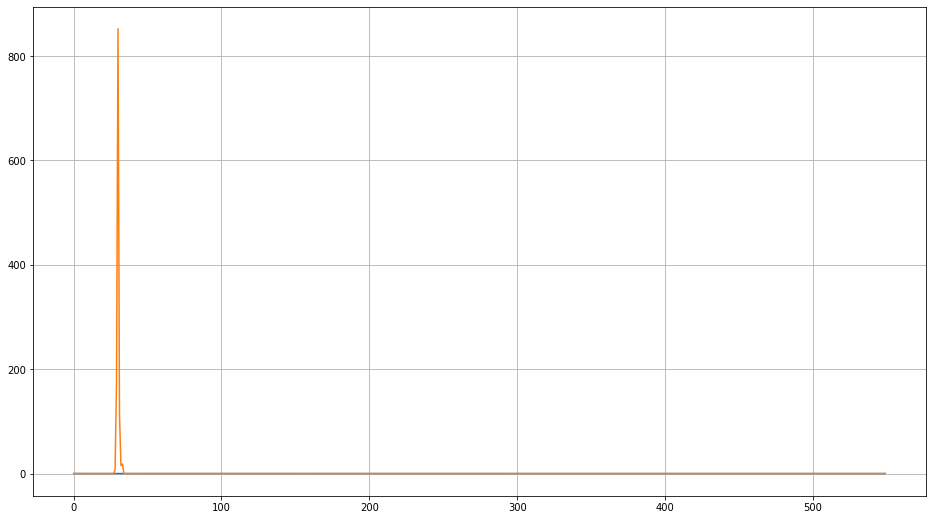

In [156]:
fig = plt.figure(figsize=(16,9))
x = np.arange(550)

pmt_waveforms = simulate_pmts(batch['energy_deposits'], key, parameters)
print(pmt_waveforms.shape)
i_pmt = 4
m = batch["S2Pmt"][0][i_pmt].max()
print(pmt_waveforms[0,i_pmt].max())
print(m)
plt.plot(x, pmt_waveforms[0,i_pmt])
plt.plot(x, batch["S2Pmt"][0][i_pmt])
plt.grid(True)